<a href="https://colab.research.google.com/github/arthbohra/Biomedical-Image-Processing/blob/main/MRI_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install Kaggle**

In [2]:
!pip install -q kaggle
!cp kaggle.json ~/.kaggle/
!mkdir ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


**Download the Dataset**

In [ ]:
! kaggle datasets download -d abhranta/brain-tumor-detection-mri

**Unzip the Dataset**

In [ ]:
!unzip \*.zip && rm*.zip

**Download Packages**

In [5]:
import json
import os
import configparser
from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16, preprocess_input
from datascience import *
import random 
import warnings
from tensorflow.keras.applications import ResNet50
import io
from tensorflow.keras import layers
warnings.filterwarnings("ignore")
from tensorflow.keras.layers import BatchNormalization
import pandas as pd
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
import shutil
from google.colab.patches import cv2_imshow
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import os
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import json
import csv
import cv2

**Plot Example**

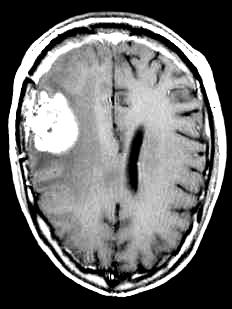

In [6]:
# plotting an example MRI scan
example = "/content/Brain_Tumor_Detection/yes/y2.jpg"
example_plot = plt.imread(example)
cv2_imshow(example_plot) 

**Create Directories**

In [7]:
paths = ["/content/training/yes", "/content/training/no", "/content/test/yes", "/content/test/no", "/content/validation/yes", "/content/validation/no"]
for path in paths:
  os.makedirs(path)

**Moving Data to Relevant Directories**

In [8]:
directory = "/content/Brain_Tumor_Detection"
categories = ["yes", "no"]
for category in categories:
    path = os.path.join(directory, category)
    i = 0
    for img in os.listdir(path):
      img_path = os.path.join(path, img)
      if i < 1000:
        shutil.move(img_path, ("/content/training/" + category))
      elif i < 1250:
        shutil.move(img_path, ("/content/test/" + category))
      elif i < 1500:
        shutil.move(img_path, ("/content/validation/" + category))
      i += 1

**Display the Distribution of the Dataset**

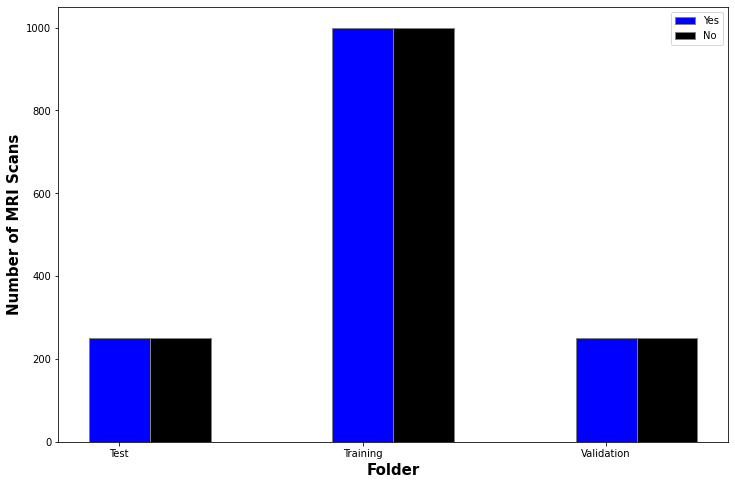

In [9]:
%matplotlib notebook
%matplotlib inline
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
Yes = [250, 1000, 250]
No = [250, 1000, 250]
 
# Set position of bar on X axis
br1 = np.arange(len(Yes))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, Yes, color ='b', width = barWidth,
        edgecolor ='grey', label ='Yes')
plt.bar(br2, No, color ='black', width = barWidth,
        edgecolor ='grey', label ='No')
 
# Adding Xticks
plt.xlabel('Folder', fontweight ='bold', fontsize = 15)
plt.ylabel('Number of MRI Scans', fontweight ='bold', fontsize = 15)
plt.xticks(np.arange(3), labels = ["Test", "Training", "Validation"])
plt.legend()
plt.show()

**Create Training Data**

In [10]:
def create_training_data(direct):
  x = []
  y = []
  directory = direct
  categories = ["yes", "no"]
  for category in categories:
    path = os.path.join(directory, category)
    class_num = categories.index(category)
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, img))
        x.append(img_array)
        y.append(class_num)
      except Exception as e:
        pass
  return np.array(x), np.array(y)

**Populate the Directories**

In [11]:
x_train, y_train = create_training_data("/content/training")
x_test, y_test = create_training_data("/content/test")
x_valid, y_valid = create_training_data("/content/validation")

**Example of Augmenting the Data**

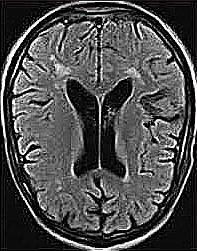

In [12]:
#read the image
img = cv2.imread("/content/test/no/no101.jpg")
#blur the image
blurred = cv2.blur(img, (3,3))

#detect the edges of the MRI scan
canny = cv2.Canny(blurred, 50, 200)

## find the bounding boxes of the MRI Scan to isolate the brain
pts = np.argwhere(canny>0)
y1,x1 = pts.min(axis=0)
y2,x2 = pts.max(axis=0)

## crop
cropped = img[y1:y2, x1:x2]

#display
cv2_imshow(cropped)

**Create Function to Augment Images**

In [13]:
def augment_image(img_path):
  #read the image
  img = cv2.imread(img_path)

  #blur the image
  blurred = cv2.blur(img, (3,3))

  #detect the edges of the MRI scan
  canny = cv2.Canny(blurred, 50, 200)

  ## find the bounding boxes of the MRI Scan to isolate the brain
  pts = np.argwhere(canny>0)
  y1,x1 = pts.min(axis=0)
  y2,x2 = pts.max(axis=0)

  ## crop
  cropped = img[y1:y2, x1:x2]

  #display
  cv2.imwrite(img_path, cropped)

**Augmenting the Entire Dataset**

In [14]:
directories = ["/content/test", "/content/validation", "/content/training"]
for directory in directories:
  categories = ["yes", "no"]
  for category in categories:
    path = os.path.join(directory, category)
    for img in os.listdir(path):
      img_path = os.path.join(path, img)
      augment_image(img_path)

**Normalizing the Dimensions of the Array**

In [15]:
def resize(directory):
  categories = ["yes", "no"]
  x = []
  y = []
  for category in categories:
    path = os.path.join(directory, category)
    for img in os.listdir(path):
      img_path = os.path.join(path, img)
      img_array = cv2.imread(os.path.join(path, img))
      resized_image = cv2.resize(img_array, dsize = (224, 224), interpolation=cv2.INTER_CUBIC)
      cv2.imwrite(img_path, resized_image)
      x.append(resized_image)
      y.append(categories.index(category))
  return np.array(x), np.array(y)

**Apply the Resizing to all of the Data**

In [27]:
x_train_new, y_train_new = resize("/content/training")
x_test_new, y_test_new = resize("/content/test")
x_valid_new, y_valid_new = resize("/content/validation")

**Display the New Data Example**

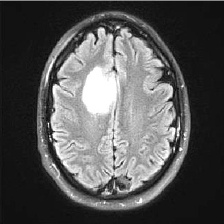

In [28]:
cv2_imshow(x_train_new[0])

**Confirm the Image Shape is Correct**

In [29]:
x_train_new[0].shape

(224, 224, 3)

**Demonstrating Data Augmentation**

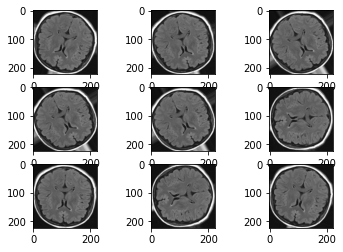

In [30]:
sample_image = cv2.imread('/content/test/no/No19.jpg')
expanded = expand_dims(sample_image, 0)
image_data_generator = ImageDataGenerator(rotation_range=90)
iterator = image_data_generator.flow(expanded, batch_size=1)
for i in range(9):
	pyplot.subplot(330 + 1 + i)
	batch = iterator.next()
	image = batch[0].astype('uint8')
	pyplot.imshow(image)
pyplot.show()

In [34]:
training_data_generator = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    preprocessing_function=preprocess_input
)
testing_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

**Creating Datasets Using Image Augmentation**

In [35]:
training_dataset = training_data_generator.flow_from_directory(
    "/content/training",
    color_mode='rgb',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    seed=30
)
validation_dataset = testing_data_generator.flow_from_directory(
    "/content/validation",
    color_mode='rgb',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    seed=30
)

Found 2000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [36]:
imgs, lbls = next(validation_dataset)

**Check Out the Final Dataset**

In [37]:
def plot_images(image_array):
  warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
  fig, axes = plt.subplots(1, 10, figsize = (20, 20))
  axes = axes.flatten()
  for img, ax in zip(image_array, axes):
    img = img
    ax.imshow(img.astype('uint8'))
    ax.axis("off")
  plt.tight_layout()
  plt.show()

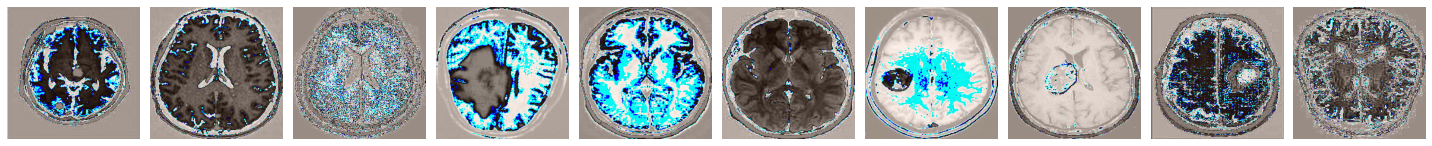

In [38]:
plot_images(imgs)

**Test Our Model with Training and Validation Sets**

In [39]:
model = Sequential()
transfer_model = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)
for layer in transfer_model.layers:
  layer.trainable = False
model.add(transfer_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
history = model.fit_generator(training_dataset, epochs = 20, steps_per_epoch = 40, validation_data = validation_dataset, validation_steps = 20)

Epoch 1/20
40/40 [==============================] - 23s 481ms/step - loss: 0.3650 - accuracy: 0.8445 - val_loss: 0.1255 - val_accuracy: 0.9406
Epoch 2/20
40/40 [==============================] - 18s 449ms/step - loss: 0.2173 - accuracy: 0.9138 - val_loss: 0.0722 - val_accuracy: 0.9740
Epoch 3/20
40/40 [==============================] - 20s 500ms/step - loss: 0.1324 - accuracy: 0.9555 - val_loss: 0.0753 - val_accuracy: 0.9750
Epoch 4/20
40/40 [==============================] - 18s 465ms/step - loss: 0.1296 - accuracy: 0.9541 - val_loss: 0.0505 - val_accuracy: 0.9875
Epoch 5/20
40/40 [==============================] - 18s 451ms/step - loss: 0.1050 - accuracy: 0.9668 - val_loss: 0.0650 - val_accuracy: 0.9805
Epoch 6/20
40/40 [==============================] - 19s 494ms/step - loss: 0.0847 - accuracy: 0.9758 - val_loss: 0.0454 - val_accuracy: 0.9844
Epoch 7/20
40/40 [==============================] - 18s 454ms/step - loss: 0.0714 - accuracy: 0.9739 - val_loss: 0.0474 - val_accuracy: 0.9805

**Graph Our Accuracy and Loss Functions**

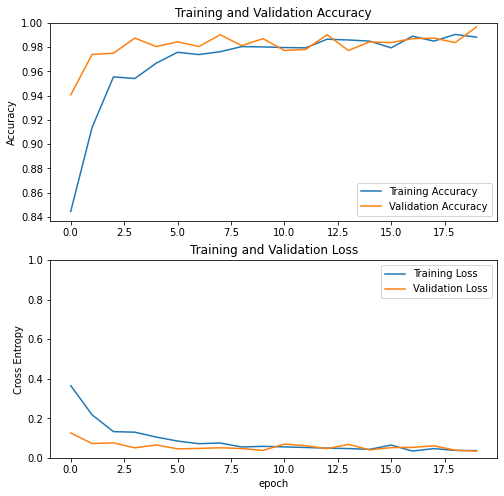

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [50]:
def preprocess_imgs(set_name, img_size):
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

X_train_prep = preprocess_imgs(set_name= x_train_new, img_size=(224, 224))
X_test_prep = preprocess_imgs(set_name=x_test_new, img_size=(224, 224))
X_val_prep = preprocess_imgs(set_name= x_valid_new, img_size=(224, 224))

In [ ]:
predictions = model.predict(x_test_new)
predictions = [0 if x>0.5 else 1 for x in predictions]
predictions

In [54]:
from sklearn import metrics
print('Accuracy score is :', np.round(metrics.accuracy_score(y_test_new, predictions),4))
print('Precision score is :', np.round(metrics.precision_score(y_test_new, predictions, average='weighted'),4))
print('Recall score is :', np.round(metrics.recall_score(y_test_new, predictions, average='weighted'),4))
print('F1 Score is :', np.round(metrics.f1_score(y_test_new, predictions, average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test_new, predictions),4))

print('\t\tClassification Report:\n', metrics.classification_report(y_test_new, predictions))

Accuracy score is : 0.952
Precision score is : 0.9555
Recall score is : 0.952
F1 Score is : 0.9519
Cohen Kappa Score: 0.904
		Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95       250
           1       0.92      1.00      0.95       250

    accuracy                           0.95       500
   macro avg       0.96      0.95      0.95       500
weighted avg       0.96      0.95      0.95       500



In [55]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_9 (ModuleWrap (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 100352)            0         
_________________________________________________________________
module_wrapper_10 (ModuleWra (None, 100352)            401408    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               25690368  
_________________________________________________________________
module_wrapper_11 (ModuleWra (None, 256)               1024      
_________________________________________________________________
activation_3 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              